In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from econml.dml import CausalForestDML
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import IV2SLS

In [2]:
df = pd.read_stata('mroz.dta')
df = df.dropna(subset=['wage'])
df['log_wage'] = np.log(df['wage'])
df

,inlf,hours,kidslt6,kidsge6,age,educ,wage,repwage,hushrs,husage,...,mtr,motheduc,fatheduc,unem,city,exper,nwifeinc,lwage,expersq,log_wage
0,1.0,1610.0,1.0,0.0,32.0,12.0,3.3540,2.65,2708.0,34.0,...,0.7215,12.0,7.0,5.0,0.0,14.0,10.910060,1.210154,196.0,1.210154
1,1.0,1656.0,0.0,2.0,30.0,12.0,1.3889,2.65,2310.0,30.0,...,0.6615,7.0,7.0,11.0,1.0,5.0,19.499981,0.328512,25.0,0.328512
2,1.0,1980.0,1.0,3.0,35.0,12.0,4.5455,4.04,3072.0,40.0,...,0.6915,12.0,7.0,5.0,0.0,15.0,12.039910,1.514138,225.0,1.514138
3,1.0,456.0,0.0,3.0,34.0,12.0,1.0965,3.25,1920.0,53.0,...,0.7815,7.0,7.0,5.0,0.0,6.0,6.799996,0.092123,36.0,0.092123
4,1.0,1568.0,1.0,2.0,31.0,14.0,4.5918,3.60,2000.0,32.0,...,0.6215,12.0,14.0,9.5,1.0,7.0,20.100060,1.524272,49.0,1.524272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,1.0,680.0,0.0,5.0,36.0,10.0,2.3118,0.00,3430.0,43.0,...,0.7215,7.0,7.0,7.5,0.0,2.0,18.199980,0.838027,4.0,0.838026
424,1.0,2450.0,0.0,1.0,40.0,12.0,5.3061,6.50,2008.0,40.0,...,0.6215,7.0,7.0,5.0,1.0,21.0,22.641060,1.668857,441.0,1.668857
425,1.0,2144.0,0.0,2.0,43.0,13.0,5.8675,0.00,2140.0,43.0,...,0.5815,7.0,7.0,7.5,1.0,22.0,21.640079,1.769429,484.0,1.769429
426,1.0,1760.0,0.0,1.0,33.0,12.0,3.4091,3.21,3380.0,34.0,...,0.5815,12.0,16.0,11.0,1.0,14.0,23.999981,1.226448,196.0,1.226448


In [3]:
df.columns

Index(['inlf', 'hours', 'kidslt6', 'kidsge6', 'age', 'educ', 'wage', 'repwage',
       'hushrs', 'husage', 'huseduc', 'huswage', 'faminc', 'mtr', 'motheduc',
       'fatheduc', 'unem', 'city', 'exper', 'nwifeinc', 'lwage', 'expersq',
       'log_wage'],
      dtype='object')

In [4]:
T = df[['educ']].to_numpy().flatten() # treatment variable: education level
Y = df['log_wage'].to_numpy().flatten() # outcome variable: log wage

In [5]:
Z = df['fatheduc'].to_numpy().flatten() # instrument variable: father's education level
X = df[['age']].to_numpy() # covariates: age

In [6]:
X_train, X_test, T_train, T_test, Y_train, Y_test, Z_train, Z_test = train_test_split(X, T, Y, Z, test_size=0.2, random_state=0)

In [7]:
causal_forest_fs = CausalForestDML(discrete_treatment=False)
causal_forest_fs.fit(T_train, Z_train, X=X_train, W=None)
fs_cate = causal_forest_fs.effect(X_train)

causal_forest_rf = CausalForestDML(discrete_treatment=False)
causal_forest_rf.fit(Y_train, Z_train, X=X_train, W=None)
rf_cate = causal_forest_rf.effect(X_train)


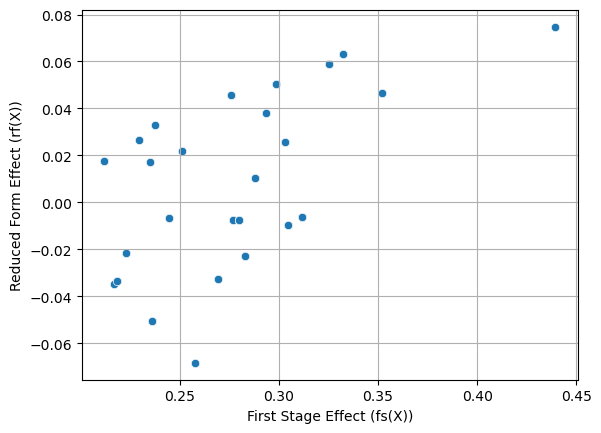

Correlation coefficient between first stage and reduced form: 0.6646947041283081
Spearman's rank correlation coefficient: 0.680177732319481
Kendall's tau rank correlation coefficient: 0.5139922702547953


In [8]:

sns.scatterplot(x=fs_cate, y=rf_cate)
plt.xlabel('First Stage Effect (fs(X))')
plt.ylabel('Reduced Form Effect (rf(X))')
plt.grid(True)
plt.show()

corr = np.corrcoef(fs_cate, rf_cate)[0, 1]
print("Correlation coefficient between first stage and reduced form:", corr)

spearman_corr, _ = scipy.stats.spearmanr(fs_cate, rf_cate)
print("Spearman's rank correlation coefficient:", spearman_corr)

kendall_corr, _ = scipy.stats.kendalltau(fs_cate, rf_cate)
print("Kendall's tau rank correlation coefficient:", kendall_corr)

In [14]:
tsls = IV2SLS(Y_train, T_train, Z_train).fit()
# tsls.summary()
r2_tsls = tsls.rsquared
print("R-squared for tsls model:", r2_tsls)

Y_test_pred = tsls.predict(T_test)
r2_rf = r2_score(Y_test, Y_test_pred)
print("R-squared for tsls model:", r2_rf)

T_test_pred = tsls.predict(Y_test)
r2_fs = r2_score(T_test, T_test_pred)
print("R-squared for tsls model:", r2_fs)

R-squared for tsls model: 0.7683446258306503
R-squared for tsls model: 0.16661748422510048
R-squared for tsls model: -24.941572566699854
